In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import numpy as np
import pandas as pd
from scipy.spatial import distance

In [2]:
# --- Load First 100k Events ---
file_path = "/home/debabrata/Work/ML_IISERK/Rajdeep_sir/data/hgcal_electron_data_0001.h5"
num_events = 50000

with h5py.File(file_path, 'r') as f:
    nhits = f['nhits'][:num_events]
    target = f['target'][:num_events]
    total_hits = int(np.sum(nhits))

    rechit_energy = f['rechit_energy'][:total_hits]
    rechit_x = f['rechit_x'][:total_hits]
    rechit_y = f['rechit_y'][:total_hits]
    rechit_z = f['rechit_z'][:total_hits]

rechit_event_indices = np.cumsum(np.concatenate([[0], nhits])).astype(np.int64)

# Compute total rechit energy per event
rechit_energy_sums = np.add.reduceat(rechit_energy, rechit_event_indices[:-1])

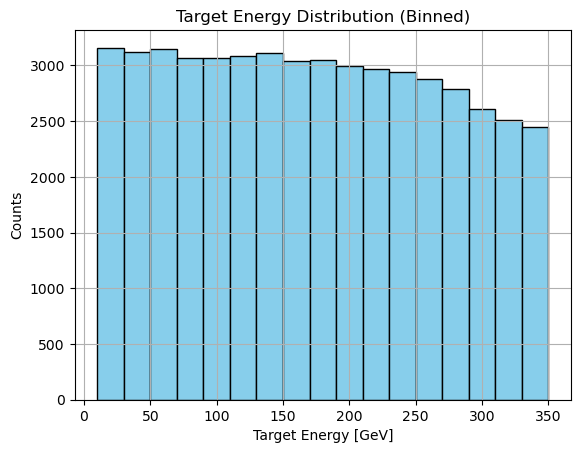

In [5]:
#Target Energy Histogram (with fixed bin size)
bin_width = 20.0  # GeV
bins = np.arange(np.floor(target.min()), np.ceil(target.max()) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_indices = np.digitize(target, bins)


plt.figure()

plt.hist(target, bins=bins, color='skyblue', edgecolor='k')
plt.xlabel('Target Energy [GeV]')
plt.ylabel('Counts')
plt.title('Target Energy Distribution (Binned)')
plt.grid(True)
plt.savefig('target_energy_distribution.png')
plt.show()


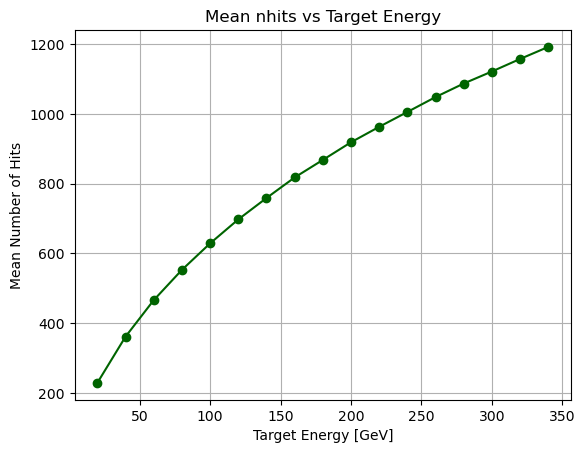

In [6]:
#  Mean nhits vs Target Energy Bin
mean_nhits_per_bin = [np.mean(nhits[bin_indices == i]) if np.any(bin_indices == i) else 0 for i in range(1, len(bins))]

plt.figure()
plt.plot(bin_centers, mean_nhits_per_bin, marker='o', color='darkgreen')
plt.xlabel('Target Energy [GeV]')
plt.ylabel('Mean Number of Hits')
plt.title('Mean nhits vs Target Energy')
plt.grid(True)
plt.savefig('mean_nhits_vs_target_energy.png')
plt.show()


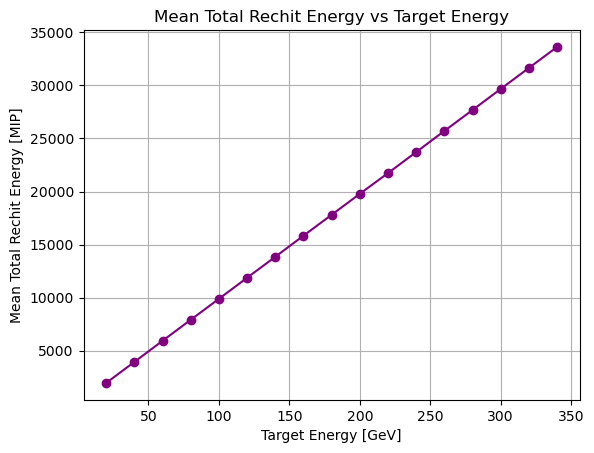

In [7]:
# Mean Total Rechit Energy per Event vs Target Energy Bin
# ---------------------------
mean_rechit_energy_per_bin = [np.mean(rechit_energy_sums[bin_indices == i]) if np.any(bin_indices == i) else 0 for i in range(1, len(bins))]

plt.figure()
plt.plot(bin_centers, mean_rechit_energy_per_bin, marker='o', color='purple')
plt.xlabel('Target Energy [GeV]')
plt.ylabel('Mean Total Rechit Energy [MIP]')
plt.title('Mean Total Rechit Energy vs Target Energy')
plt.grid(True)
plt.savefig('mean_total_rechit_energy_vs_target_energy.png')
plt.show()

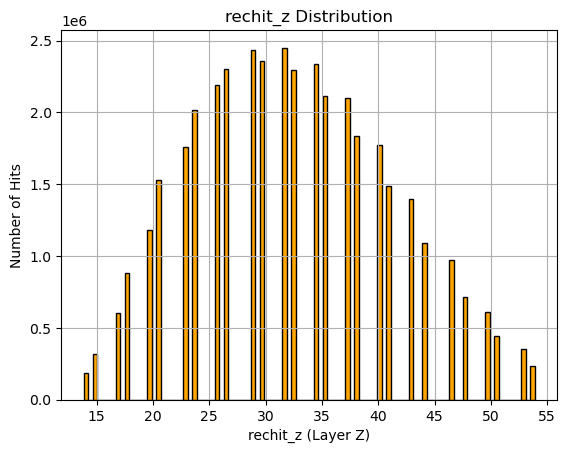

In [8]:
# rechit_z Distribution (all hits across all events)
plt.figure()
plt.hist(rechit_z, bins=100, color='orange', edgecolor='k')
plt.xlabel('rechit_z (Layer Z)')
plt.ylabel('Number of Hits')
plt.title('rechit_z Distribution')
plt.grid(True)
plt.savefig('rechit_z_distribution.png')
plt.show()

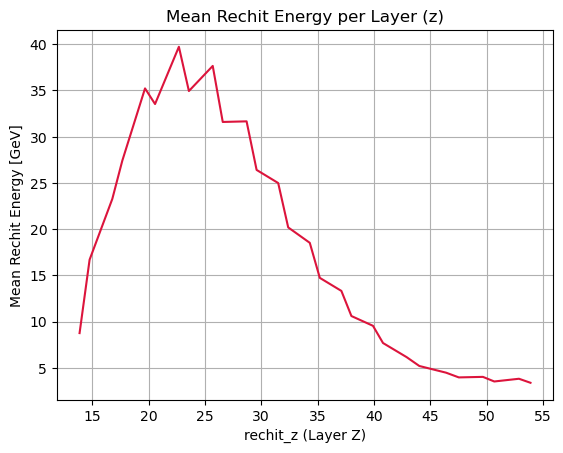

In [9]:
# Mean Rechit Energy per Layer Z
# Convert to DataFrame for easier grouping
df = pd.DataFrame({
    'z': rechit_z,
    'energy': rechit_energy
})

mean_energy_per_z = df.groupby('z')['energy'].mean()

plt.figure()
plt.plot(mean_energy_per_z.index, mean_energy_per_z.values, color='crimson')
plt.xlabel('rechit_z (Layer Z)')
plt.ylabel('Mean Rechit Energy [GeV]')
plt.title('Mean Rechit Energy per Layer (z)')
plt.grid(True)
plt.savefig('mean_rechit_energy_per_layer_z.png')
plt.show()

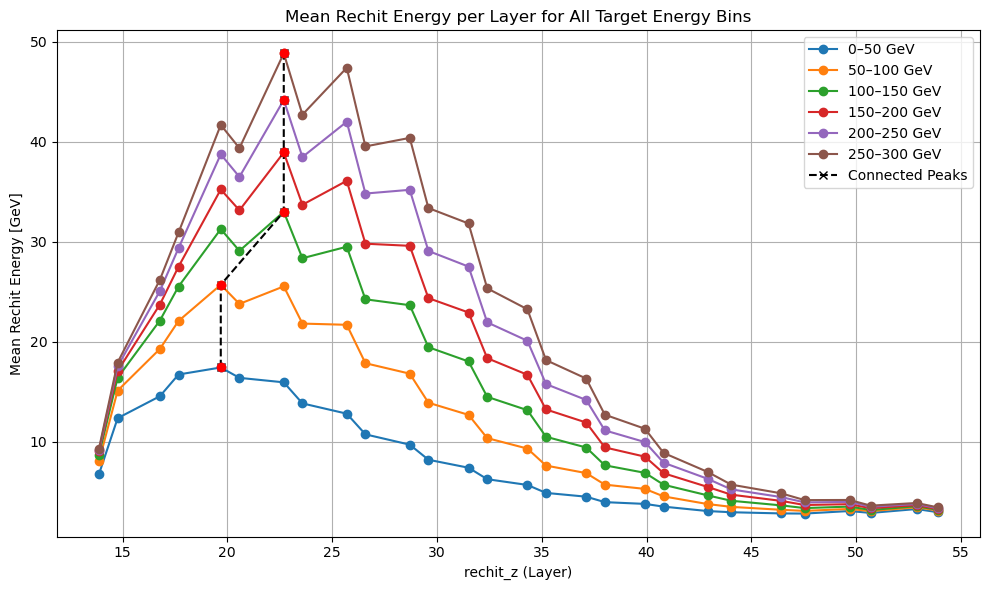

In [10]:

event_ids = np.zeros(total_hits, dtype=np.int32)
for i in range(num_events):
    start = rechit_event_indices[i]
    end = rechit_event_indices[i + 1]
    event_ids[start:end] = i

# ---------- Define Target Energy Bins ----------
bin_width = 50
bins = np.arange(0, 300 + bin_width, bin_width)  # e.g. 0-10, 10-20, ..., 100-110
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Create DataFrame for all hits
df_hits = pd.DataFrame({
    'event': event_ids,
    'rechit_z': rechit_z,
    'rechit_energy': rechit_energy,
    'target': target[event_ids]
})
# Plot all mean rechit energy per layer curves on the same figure and connect the peaks
plt.figure(figsize=(10, 6))
peak_zs = []
peak_energies = []
labels = []

for i in range(len(bins) - 1):
    low, high = bins[i], bins[i + 1]
    df_bin = df_hits[(df_hits['target'] >= low) & (df_hits['target'] < high)]
    if df_bin.empty:
        print(f"Skipping bin {low}-{high} (no data)")
        continue
    mean_energy_by_z = df_bin.groupby('rechit_z')['rechit_energy'].mean()
    z_vals = mean_energy_by_z.index.values
    energy_vals = mean_energy_by_z.values
    peak_z = z_vals[np.argmax(energy_vals)]
    peak_energy = np.max(energy_vals)
    peak_zs.append(peak_z)
    peak_energies.append(peak_energy)
    labels.append(f'{low}-{high} GeV')
    plt.plot(z_vals, energy_vals, marker='o', label=f'{low}–{high} GeV')
    plt.scatter([peak_z], [peak_energy], color='red', zorder=5)

# Connect the peaks
plt.plot(peak_zs, peak_energies, color='black', linestyle='--', marker='x', label='Connected Peaks')
plt.title('Mean Rechit Energy per Layer for All Target Energy Bins')
plt.xlabel('rechit_z (Layer)')
plt.ylabel('Mean Rechit Energy [GeV]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mean_rechit_energy_per_layer_energy_binwise.png')
plt.show()

In [11]:
# Save to new HDF5 file
with h5py.File("processed_hgcal_events.h5", "w") as f_out:
    grp = f_out.create_group("events")

    for i in range(num_events):
        start = rechit_event_indices[i]
        end = rechit_event_indices[i + 1]

        # Create group for this event
        evt_grp = grp.create_group(f"event_{i}")
        evt_grp.attrs['event_id'] = i
        evt_grp.attrs['nhits'] = end - start
        evt_grp.attrs['target_energy'] = target[i]

        # Store rechit data as datasets
        evt_grp.create_dataset("rechit_x", data=rechit_x[start:end])
        evt_grp.create_dataset("rechit_y", data=rechit_y[start:end])
        evt_grp.create_dataset("rechit_z", data=rechit_z[start:end])
        evt_grp.create_dataset("rechit_energy", data=rechit_energy[start:end])

In [12]:
with h5py.File("processed_hgcal_events.h5", "r") as f:
    evt = f["events"]["event_42"]
    x = evt["rechit_x"][:]
    y = evt["rechit_y"][:]
    z = evt["rechit_z"][:]
    e = evt["rechit_energy"][:]
    nhits = evt.attrs["nhits"]
    target = evt.attrs["target_energy"]

    print(f"Event 42: {nhits} hits, target energy = {target} GeV")


Event 42: 879 hits, target energy = 196.82664960182026 GeV


In [13]:
file_path = "processed_hgcal_events.h5"
layer_to_check = 42  # example layer

count_layer_hits = 0
events_with_mismatch = []

with h5py.File(file_path, "r") as f:
    events = list(f["events"].keys())

    for evt_name in events:
        evt = f["events"][evt_name]

        # Attributes
        nhits = evt.attrs["nhits"]

        # Hit arrays
        x = evt["rechit_x"][:]
        y = evt["rechit_y"][:]
        z = evt["rechit_z"][:]
        e = evt["rechit_energy"][:]

        # Consistency check
        if not (len(x) == len(y) == len(z) == len(e) == nhits):
            events_with_mismatch.append(evt_name)

        # Check if this event has any hits in layer 42
        if np.any(z == layer_to_check):
            count_layer_hits += 1

# Final output
print(f"\n✅ Verified all {len(events)} events.")
if events_with_mismatch:
    print(f"❌ Found {len(events_with_mismatch)} mismatched events: {events_with_mismatch}")
else:
    print("✅ All hit arrays match their nhits attribute.")

print(f"🔍 Number of events with hits in layer {layer_to_check}: {count_layer_hits}")


✅ Verified all 50000 events.
✅ All hit arrays match their nhits attribute.
🔍 Number of events with hits in layer 42: 0


In [15]:

with h5py.File("processed_hgcal_events.h5", "r") as f:
    evt = f["events"]["event_42"]
    nhits = evt.attrs["nhits"]

    print("nhits:", nhits)
    print("rechit_x length:", len(evt["rechit_x"]))
    print("rechit_y length:", len(evt["rechit_y"]))
    print("rechit_z length:", len(evt["rechit_z"]))
    print("rechit_energy length:", len(evt["rechit_energy"]))

nhits: 879
rechit_x length: 879
rechit_y length: 879
rechit_z length: 879
rechit_energy length: 879


In [22]:
from scipy.spatial import cKDTree
from tqdm import tqdm
file_path = "/home/debabrata/Work/ML_IISERK/Rajdeep_sir/data/hgcal_electron_data_0001.h5"
num_events = 50000

with h5py.File(file_path, 'r') as f:
    nhits = f['nhits'][:num_events]
    target = f['target'][:num_events]
    total_hits = int(np.sum(nhits))

    rechit_x = f['rechit_x'][:total_hits]
    rechit_y = f['rechit_y'][:total_hits]
    rechit_z = f['rechit_z'][:total_hits]
    rechit_energy = f['rechit_energy'][:total_hits]

rechit_event_indices = np.cumsum(np.concatenate([[0], nhits])).astype(np.int64)

# Determin
# Determine all unique layers
all_layers = np.unique(rechit_z)
num_layers = len(all_layers)
layer_to_index = {layer: idx for idx, layer in enumerate(all_layers)}

# Output structure: list of dicts, one per event
event_data = []

for i in tqdm(range(num_events), desc="Processing events"):
    start = rechit_event_indices[i]
    end = rechit_event_indices[i + 1]

    x = rechit_x[start:end]
    y = rechit_y[start:end]
    z = rechit_z[start:end]
    e = rechit_energy[start:end]

    event_dict = {
        "event_id": i,
        "nhits": end - start,
        "target": target[i],
        "sum_energy_per_layer": np.zeros(num_layers),
        "E1_over_E7": np.zeros(num_layers),
        "E7_over_E19": np.zeros(num_layers),
    }

    # For each layer in the event
    for layer in np.unique(z):
        layer_idx = layer_to_index[layer]
        mask = z == layer
        x_l, y_l, e_l = x[mask], y[mask], e[mask]

        if len(e_l) == 0:
            continue

        # Sum of energy in the layer
        event_dict["sum_energy_per_layer"][layer_idx] = np.sum(e_l)

        # Find E1 and E7 and E19
        max_idx = np.argmax(e_l)
        x_seed, y_seed = x_l[max_idx], y_l[max_idx]

        coords = np.stack([x_l, y_l], axis=1)
        tree = cKDTree(coords)
        dists, idxs = tree.query([x_seed, y_seed], k=min(len(e_l), 20))
        idxs = np.atleast_1d(idxs)

        E1 = e_l[max_idx]
        E7 = np.sum(e_l[idxs[:7]]) if len(idxs) >= 7 else np.sum(e_l[idxs])
        E19 = np.sum(e_l[idxs[:19]]) if len(idxs) >= 19 else np.sum(e_l[idxs])

        event_dict["E1_over_E7"][layer_idx] = E1 / E7 if E7 > 0 else 0
        event_dict["E7_over_E19"][layer_idx] = E7 / E19 if E19 > 0 else 0

    event_data.append(event_dict)

# Save to HDF5
output_path = "processed_event_features.h5"
with h5py.File(output_path, "w") as f_out:
    f_out.create_dataset("event_id", data=[e["event_id"] for e in event_data])
    f_out.create_dataset("nhits", data=[e["nhits"] for e in event_data])
    f_out.create_dataset("target", data=[e["target"] for e in event_data])
    f_out.create_dataset("sum_energy_per_layer", data=np.array([e["sum_energy_per_layer"] for e in event_data]))
    f_out.create_dataset("E1_over_E7", data=np.array([e["E1_over_E7"] for e in event_data]))
    f_out.create_dataset("E7_over_E19", data=np.array([e["E7_over_E19"] for e in event_data]))

all_layers.tolist()

Processing events: 100%|██████████| 50000/50000 [02:43<00:00, 306.17it/s]


[13.8774995803833,
 14.767499923706055,
 16.782499313354492,
 17.672500610351562,
 19.6875,
 20.577499389648438,
 22.6924991607666,
 23.582500457763672,
 25.697500228881836,
 26.587499618530273,
 28.702499389648438,
 29.592500686645508,
 31.50749969482422,
 32.397499084472656,
 34.3125,
 35.20249938964844,
 37.11750030517578,
 38.00749969482422,
 39.92250061035156,
 40.8125,
 42.907501220703125,
 44.037498474121094,
 46.412498474121094,
 47.54249954223633,
 49.68199920654297,
 50.6879997253418,
 52.881500244140625,
 53.903499603271484]

In [26]:
event_id = 0

with h5py.File("processed_event_features.h5", "r") as f:
    nh = f["nhits"][event_id]
    tgt = f["target"][event_id]
    e_layer = f["sum_energy_per_layer"][event_id]  # shape (num_layers,)
    e1e7 = f["E1_over_E7"][event_id]
    e7e19 = f["E7_over_E19"][event_id]

print(f"Event {event_id}")
print(f"  nhits: {nh}")
print(f"  target energy: {tgt:.2f} GeV")
print(f"  sum_energy_per_layer: {e_layer}")
print(f"  E1/E7 per layer: {e1e7}")
print(f"  E7/E19 per layer: {e7e19}")


Event 0
  nhits: 1115
  target energy: 286.61 GeV
  sum_energy_per_layer: [  29.80688095  116.78504753  551.95911634  867.93190998 1394.83376276
 1434.38567674 1998.59047413 2083.45388168 2828.2884506  2199.64837229
 2484.16228199 2150.28352338 2154.98109341 1462.80953884 1506.62059063
 1147.40226871 1016.80520219  690.49596423  693.34092939  497.81487
  256.36888671  182.39130574  186.19755447   61.64680946   67.85225475
   44.62258619   51.54618692   46.679465  ]
  E1/E7 per layer: [1.         0.86800905 0.7267833  0.78229298 0.60652137 0.67661991
 0.50433739 0.64292011 0.48167001 0.62857417 0.49946834 0.51442174
 0.42571003 0.49178586 0.33687873 0.37297212 0.32053507 0.40800306
 0.29706221 0.47549398 0.26303591 0.36800504 0.30880936 0.45312765
 0.31944688 0.51120183 0.521132   0.42355503]
  E7/E19 per layer: [1.         0.98551233 0.88865833 0.91837476 0.92678563 0.95143569
 0.86483526 0.93767854 0.86614963 0.91703022 0.83374869 0.84942921
 0.83410574 0.88943768 0.81167287 0.7809876

In [25]:
import pandas as pd

with h5py.File("processed_event_features.h5", "r") as f:
    df = pd.DataFrame({
        "event_id": f["event_id"][:],
        "nhits": f["nhits"][:],
        "target": f["target"][:],
    })

    # Add flattened per-layer features
    sum_e = f["sum_energy_per_layer"][:]
    e1e7 = f["E1_over_E7"][:]
    e7e19 = f["E7_over_E19"][:]

# Add per-layer columns
num_layers = sum_e.shape[1]
for l in range(num_layers):
    df[f"sumE_L{l}"] = sum_e[:, l]
    df[f"E1_E7_L{l}"] = e1e7[:, l]
    df[f"E7_E19_L{l}"] = e7e19[:, l]

df.head()


,event_id,nhits,target,sumE_L0,E1_E7_L0,E7_E19_L0,sumE_L1,E1_E7_L1,E7_E19_L1,sumE_L2,...,E7_E19_L24,sumE_L25,E1_E7_L25,E7_E19_L25,sumE_L26,E1_E7_L26,E7_E19_L26,sumE_L27,E1_E7_L27,E7_E19_L27
0,0,1115,286.606530,29.806881,1.000000,1.0,116.785048,0.868009,0.985512,551.959116,...,0.459526,44.622586,0.511202,0.546684,51.546187,0.521132,0.460167,46.679465,0.423555,0.915084
1,1,1048,260.230767,60.289388,0.804771,1.0,154.114308,0.826672,1.000000,418.088728,...,0.500373,39.322538,0.343734,0.764309,31.082570,0.345549,0.633309,20.599729,0.558402,1.000000
2,2,684,122.320895,40.690735,0.887116,1.0,158.744283,0.750754,0.932934,338.596367,...,1.000000,24.565086,0.263729,1.000000,11.780640,1.000000,1.000000,16.806829,0.497424,1.000000
3,3,491,64.871587,21.497051,0.957860,1.0,68.508469,0.968880,1.000000,193.359974,...,1.000000,3.351710,1.000000,1.000000,2.195675,0.518917,1.000000,0.000000,0.000000,0.000000
4,4,1029,237.140564,13.897627,0.464893,1.0,23.198348,0.657382,1.000000,118.975507,...,0.511000,50.812943,0.407180,0.458899,97.485511,0.421564,0.484717,28.143846,0.223128,0.815003
